In [39]:
%matplotlib inline

# General Libraries
import re
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

Load the Crime data.

In [40]:
crime_data = []
crime_labels = []
with open("../train.csv", "rb") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    first_row = True
    for row in reader:
        data = [y for x, y in enumerate(row) if x != 1]
        name = [y for x, y in enumerate(row) if x == 1]
        
        if first_row:
            first_row = False
            feature_names = data
            print feature_names
        else:
            crime_data.append(data)
            crime_labels.append(name)

print crime_data[:1]

['Dates', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y']
[['2015-05-13 23:53:00', 'WARRANT ARREST', 'Wednesday', 'NORTHERN', 'ARREST, BOOKED', 'OAK ST / LAGUNA ST', '-122.425891675136', '37.7745985956747']]


Divide the Crime data into Train data, test data, mini train data, and dev sets

In [41]:
# Divide the Crime training set into train data, test data, dev data
train_data, train_labels = crime_data[:500000], crime_labels[:500000]
crime_test, crime_test_labels = crime_data[500000:], crime_labels[500000:]
num_test = len(crime_test)
print num_test
dev_data, dev_labels = crime_test[:num_test/2], crime_test_labels[:num_test/2]
testX_data, testX_labels = crime_test[num_test/2:], crime_test_labels[num_test/2:]
mini_train_data, mini_train_labels = crime_data[200000:300000], crime_labels[200000:300000]

print "Size of train data: ", len(train_data)
print "Size of dev data: ", len(dev_data)
print "Size of test data: ", len(test_data)

378049
Size of train data:  500000
Size of dev data:  189024
Size of test data:  884262


In [42]:
data_df = pd.read_csv("../train.csv")
crime_data = np.array(data_df[['Dates', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y']].values)
crime_labels = np.array(data_df[['Category']].values.ravel())
print crime_data[:1]

[['2015-05-13 23:53:00' 'WARRANT ARREST' 'Wednesday' 'NORTHERN'
  'ARREST, BOOKED' 'OAK ST / LAGUNA ST' -122.425891675136 37.7745985956747]]


In [43]:
test_data_df = pd.read_csv("../test.csv")
test_data = np.array(test_data_df.values)
print test_data[:1]
test_data_df.columns.values

[[0L '2015-05-10 23:59:00' 'Sunday' 'BAYVIEW' '2000 Block of THOMAS AV'
  -122.39958770418998 37.7350510103906]]


array(['Id', 'Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y'], dtype=object)

In [44]:
data_xy = np.array(data_df[['X', 'Y']].values)
test_xy = np.array(test_data_df[['X', 'Y']].values)

In [35]:
print cl_index[:30]

[  0.   0.   0.   0.   8.  14.  14.  15.  22.  27.  27.  30.  38.   0.  15.
  15.  38.  14.  15.  38.  14.  14.  38.  38.   3.  35.   3.  10.  30.  30.]


In [45]:
districts = ['NORTHERN', 'PARK', 'INGLESIDE', 'BAYVIEW', 'RICHMOND', 'CENTRAL', 'TARAVAL', 'TENDERLOIN', 'MISSION', 'SOUTHERN']

cl_index = np.zeros(data_xy.shape[0])
for i in range(len(districts)):
    data_cl_df = data_df[data_df['PdDistrict'] == districts[i]][['X', 'Y']]
    data_cl_xy = np.array(data_df[['X', 'Y']].values)
    index = data_df[data_df['PdDistrict'] == districts[i]].index.tolist()
    data_cl_df['index'] = index
    km = KMeans(n_clusters=5)
    X_kfit = km.fit(data_cl_xy)
    clusters = X_kfit.labels_ + i*5
    cl_index[index] = clusters
    
print cl_index[:30]

print data_cl_df[:10]

[  2.   2.   2.   2.   5.  10.  10.  18.  20.  29.  29.  30.  35.   2.  18.
  18.  35.  10.  18.  35.  10.  10.  35.  35.   3.  38.   3.  13.  30.  30.]
             X          Y  index
35 -122.391846  37.778125     35
40 -122.405295  37.786307     40
41 -122.422128  37.773033     41
52 -122.403285  37.787306     52
53 -122.397616  37.777392     53
54 -122.420347  37.771769     54
55 -122.399802  37.788007     55
57 -122.411279  37.771579     57
63 -122.395098  37.794059     63
64 -122.411637  37.771787     64


In [46]:
print cl_index.shape

(878049L,)


In [47]:
clt_index = np.zeros(test_xy.shape[0])
for i in range(len(districts)):
    test_cl_df = test_data_df[test_data_df['PdDistrict'] == districts[i]][['X', 'Y']]
    test_cl_xy = np.array(test_cl_df[['X','Y']].values)
    index = test_data_df[test_data_df['PdDistrict'] == districts[i]].index.tolist()
    test_cl_df['index'] = index
    test_clusters = km.predict(test_cl_xy) + i*5
    
    clt_index[index] = test_clusters
print clt_index[:30]
print test_cl_df[:10]

[ 18.  18.   0.  14.  14.  34.  13.  13.  40.  25.  13.  40.  40.  25.  25.
  35.  34.  13.   0.   0.   0.  40.  25.  13.   0.  22.   0.  45.  14.  32.]
             X          Y  index
27 -122.403405  37.775421     27
36 -122.410939  37.779212     36
47 -122.410294  37.782231     47
50 -122.405619  37.778505     50
56 -122.413161  37.777457     56
64 -122.406521  37.785063     64
65 -122.403405  37.775421     65
66 -122.403405  37.775421     66
69 -122.407634  37.784189     69
70 -122.403405  37.775421     70


The next section has all UTIL functions

In [48]:
print cl_index.shape
print cl_index[:20]
print clt_index.shape
print clt_index[:20]

(878049L,)
[  2.   2.   2.   2.   5.  10.  10.  18.  20.  29.  29.  30.  35.   2.  18.
  18.  35.  10.  18.  35.]
(884262L,)
[ 18.  18.   0.  14.  14.  34.  13.  13.  40.  25.  13.  40.  40.  25.  25.
  35.  34.  13.   0.   0.]


In [59]:
from datetime import datetime
def convert_date(date_val):
    date_list = []
    date, time = date_val.split()
    date_list.append(int(date.split('-')[0]))
    date_list.append(int(date.split('-')[1]))
    date_list.append(int(date.split('-')[2]))
    time_in_min = int(time.split(':')[0]) * 60.0 + int(time.split(':')[1])
    date_list.append(time_in_min)
    date_list.append(int(time.split(':')[0]))
    time_hour = int(time.split(':')[0])
    if time_hour < 6:
        time_of_day = 'Twilight'
    elif time_hour < 12:
        time_of_day = 'Morning'
    elif time_hour < 18:
        time_of_day = 'Afternoon'
    else:
        time_of_day = 'Night'
    date_list.append(time_of_day)
    return date_list

print train_data[0][0]
print convert_date(train_data[0][0])

def find_mean_std(train_data, index):
    data = []
    for row in train_data:
        data.append(float(row[index]))
    
    data_arr = np.array(data, dtype=np.float32)
    print np.mean(data_arr)
    data_dict = {}
    data_dict['mean'] = np.mean(data_arr)
    data_dict['std'] = np.std(data_arr)
    return data_dict

2015-05-13 23:53:00
[2015, 5, 13, 1433.0, 23, 'Night']


In [50]:
date_arr = convert_date(train_data[0][0])
year, month, day, time_in_min, hour, time_of_day = date_arr

cyear = [(year < 2006) * 1, (year < 2008) * 1, (year < 2010) * 1, (year < 2012)*1, (year < 2015)*1, (year == 2015)*1]
print cyear

[0, 0, 0, 0, 0, 1]


Initialized Arrays

In [51]:
districts = ['NORTHERN', 'PARK', 'INGLESIDE', 'BAYVIEW', 'RICHMOND', 'CENTRAL', 'TARAVAL', 'TENDERLOIN', 'MISSION', 'SOUTHERN']
week_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daytime = ['Twilight', 'Morning', 'Afternoon', 'Night']
year_range = ['2003-2006', '2006-2009', '2009-2012', 'After 2015']
crime_year = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
crime_month = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
crime_day = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29 ,30 ,31]
crime_hour = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

Feature Engineering - Section I:

1) Crime Date - Normalization

2) Longitude & Latitude - Normalization

In [52]:
''' Crime Date - Normalization '''

year_data = []
mon_data = []
day_data = []
time_data = []
time_of_day_data = []
for row in crime_data:
    date_arr = convert_date(row[0])
    year_data.append(float(date_arr[0]))
    mon_data.append(float(date_arr[1]))
    day_data.append(float(date_arr[2]))
    time_data.append(float(date_arr[3]))
    time_of_day_data.append(date_arr[5])
                     

year_arr = np.array(year_data, dtype=np.float32)
mon_arr = np.array(mon_data, dtype=np.float32)
day_arr = np.array(day_data, dtype=np.float32)
time_arr = np.array(time_data, dtype=np.float32)
time_of_day_arr = np.array(time_of_day_data)

date_dict = {}
date_dict['mean_year'] = np.mean(year_arr)
date_dict['std_year'] = np.std(year_arr)                               
date_dict['mean_mon'] = np.mean(mon_arr)
date_dict['std_mon'] = np.std(mon_arr)
date_dict['mean_day'] = np.mean(day_arr)
date_dict['std_day'] = np.std(day_arr)
date_dict['mean_time'] = np.mean(time_arr)
date_dict['std_time'] = np.std(time_arr)


''' Longitude & Latitude - Normalization '''
long_dict = find_mean_std(train_data, 6)
lat_dict = find_mean_std(train_data, 7)

-122.423
37.7675


Preparing the Data

In [130]:

def get_formatted_data(train_data):
    format_data = []
    count = 0
    
    for i in range(len(train_data)):
        count += 1
        data = []
        row = train_data[i]
        
        ''' Data Preparation - Crime date '''
        
        #date_list = convert_date(row[0])
        # [2015, 5, 13, 1433.0, 23, 'Night']
        
        date_arr = convert_date(row[0])
        year, month, day, time_in_min, hour, time_of_day = date_arr
        
        norm_year = [(year < 2010)*1, (year>=2010)*1]
        data.extend(norm_year)
        
        norm_month = [1 if month == m else 0 for m in crime_month]
        data.extend(norm_month)
        
        norm_day = [1 if day == d else 0 for d in crime_day]
        data.extend(norm_day)
        
        #norm_hour = [1 if hour == h else 0 for h in crime_hour]
        #data.extend(norm_hour)
        
        # Time of the day preparation
        day_time = [1 if time_of_day == td else 0 for td in daytime]
        data.extend(day_time)
        
        
        ''' Data Preparation - Day of the Week '''
        wk_day = row[2]
        
        crime_week_day = [1 if wk_day == d else 0 for d in week_day] 
        data.extend(crime_week_day) # Normalized
        
        ''' Data Preparation - District '''
        pdd = row[3]
        pddistrict = [1 if pdd == d else 0 for d in districts] # Normalized
        data.extend(pddistrict)
        
        ''' Data Preparation - Longitude & Latitude '''
        longitude = float(row[6])
        long_norm = (abs(longitude) - abs(long_dict['mean']))/long_dict['std'] # Normalized
        latitude = float(row[7])
        lat_norm = (abs(latitude) - abs(lat_dict['mean']))/lat_dict['std'] # Normalized
        
        data.append(long_norm)
        data.append(lat_norm)
        
        #cluster_label = cl_index[i]
        #data.append(cluster_label)
        
        ''' Data Preparation - Address '''
        
        address = row[5].lower()
        addr = [1 if 'block' in address else 0] # Requires major improvement
        data.extend(addr)
        
        # Explore external map source
        
        ''' Quantify the data '''
        format_data.append(np.array(data, dtype=np.float32))           
        
    return format_data
    
    
crimeX = np.array(get_formatted_data(crime_data), dtype=np.float32)
print crimeX[:1]

[[ 0.          1.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          1.
   0.          0.          1.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.12929684  0.29712132  0.        ]]


In [131]:
print crimeX[4:5]
print crimeX.shape

[[ 0.          1.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          1.
   0.          0.          1.          0.          0.          0.          0.
   0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.6373859   0.16966379  1.        ]]
(878049L, 69L)


In [132]:
print "CrimeX Data shape: ", crimeX.shape
print "CrimeX Label shape: ", np.array(crime_labels).shape

CrimeX Data shape:  (878049L, 69L)
CrimeX Label shape:  (878049L,)


Building the Logistic Regression model on the entire Crime Training Data

In [28]:
params = {'C':[0.001, 0.01, 0.1, 0.2, 1, 10, 100]}
clf = GridSearchCV(LogisticRegression(penalty='l2'), params)
clf.fit(crimeX[:10000], crime_labels[:10000])
print clf.best_params_

{'C': 0.01}


C:\Users\pgundugola\Downloads\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\sklearn\cross_validation.py:417: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


In [56]:
lr = LogisticRegression(penalty='l2', C=0.01, tol=0.01)
lr.fit(crimeX, crime_labels)
print "Completed training with best C"

Completed training with best C


In [60]:
print test_data[:5]

[[0L '2015-05-10 23:59:00' 'Sunday' 'BAYVIEW' '2000 Block of THOMAS AV'
  -122.39958770418998 37.7350510103906]
 [1L '2015-05-10 23:51:00' 'Sunday' 'BAYVIEW' '3RD ST / REVERE AV'
  -122.391522893042 37.7324323864471]
 [2L '2015-05-10 23:50:00' 'Sunday' 'NORTHERN' '2000 Block of GOUGH ST'
  -122.426001954961 37.7922124386284]
 [3L '2015-05-10 23:45:00' 'Sunday' 'INGLESIDE' '4700 Block of MISSION ST'
  -122.437393972517 37.7214120621391]
 [4L '2015-05-10 23:45:00' 'Sunday' 'INGLESIDE' '4700 Block of MISSION ST'
  -122.437393972517 37.7214120621391]]


In [133]:
def get_formatted_test_data(test_data):
    format_data = []
    count = 0
    
    for i in range(len(test_data)):
        count += 1
        data = []
        
        row = test_data[i]
        
        ''' Data Preparation - Date '''
        date_arr = convert_date(row[1])
        year, month, day, time_in_min, hour, time_of_day = date_arr
        
        #norm_year = [1 if year == y else 0 for y in crime_year]
        norm_year = [(year < 2010)*1, (year>=2010)*1]
        data.extend(norm_year)
        
        norm_month = [1 if month == m else 0 for m in crime_month]
        data.extend(norm_month)
        
        norm_day = [1 if day == d else 0 for d in crime_day]
        data.extend(norm_day)
        
        #norm_hour = [1 if hour == h else 0 for h in crime_hour]
        #data.extend(norm_hour)
        
        # Time of the day preparation
        day_time = [1 if time_of_day == td else 0 for td in daytime]
        data.extend(day_time)
        
        ''' Data Preparation - Day of the Week '''
        wk_day = row[2]
        
        crime_week_day = [1 if wk_day == d else 0 for d in week_day] 
        data.extend(crime_week_day) # Normalized
        
        pdd = row[3]
        pddistrict = [1 if pdd == d else 0 for d in districts]
        data.extend(pddistrict)
        
        longitude = float(row[5])
        long_norm = (abs(longitude) - abs(long_dict['mean']))/long_dict['std']
        latitude = float(row[6])
        lat_norm = (abs(latitude) - abs(lat_dict['mean']))/lat_dict['std']
        data.append(long_norm)
        data.append(lat_norm)
        
        #test_cluster_label = clt_index[i]
        #data.append(test_cluster_label)
        
        if 'block' in row[4].lower():
            address = 1
        else:
            address = 0
        data.append(address)
        format_data.append(np.array(data, dtype=np.float32))           
        
    return format_data
    
    

testX = np.array(get_formatted_test_data(test_data), dtype=np.float32)

        

In [134]:
print testX.shape

(884262L, 69L)


In [64]:
print probs.shape
print probs[:1]

(884262L, 39L)
[[  5.76719885e-03   1.38896575e-01   4.74332077e-04   9.72481207e-04
    4.10956684e-02   2.23499731e-03   2.96142556e-03   2.67066516e-02
    6.04037428e-03   7.58891098e-04   4.81646263e-04   9.02829216e-04
    2.67756690e-03   7.90894597e-03   4.12690830e-04   5.20545838e-03
    1.53400514e-01   2.01001208e-03   4.43977954e-04   5.77654522e-02
    7.90715702e-02   1.12325078e-01   4.65338712e-06   7.79030731e-04
    3.34635433e-03   2.94284835e-02   3.29775434e-03   2.94264581e-02
    6.59167111e-03   4.10996069e-04   4.43699061e-03   8.25669814e-04
    3.45173831e-02   5.30678249e-09   6.47385903e-03   8.88071084e-02
    8.54435409e-02   3.58083515e-02   2.18873530e-02]]


In [59]:
print probs.shape
print probs[:1]

(884262L, 39L)
[[ 0.00598014  0.14235451  0.00039644  0.00095056  0.04091489  0.00200755
   0.00284076  0.01751568  0.0054245   0.00065421  0.00042781  0.00088631
   0.00179967  0.00680445  0.00042315  0.00505384  0.15562875  0.00179362
   0.00036821  0.05546664  0.08141095  0.11349672  0.00025786  0.00034429
   0.00303172  0.03292385  0.00276192  0.0313208   0.00717204  0.00044138
   0.00499776  0.0007008   0.03670595  0.00025392  0.00626717  0.08456407
   0.08833596  0.03474202  0.02257913]]


In [63]:
probs = lr.predict_proba(testX)

In [65]:
import gzip
with gzip.open('submission-matrix-4.csv.gz', 'wb') as f:
    out = csv.writer(f, lineterminator='\n')
    out.writerow(['Id'] + list(np.unique(crime_labels)))
    
    for i, prob in enumerate(probs):
        out.writerow([i] + list(prob))
print "Job completed"     

Job completed


In [135]:
pca = PCA()
pca.fit_transform(crimeX)

total_variance = pca.explained_variance_
print "Total variance: ", sum(total_variance)
print total_variance
print total_variance.shape
print sum(total_variance[:30])
print sum(total_variance[:3]/sum(total_variance))

Total variance:  369.286215423
[  3.63244019e+02   1.06283918e+00   4.93083850e-01   3.28120498e-01
   2.42075275e-01   2.06205996e-01   1.67649688e-01   1.59019047e-01
   1.50973743e-01   1.45545924e-01   1.42528652e-01   1.41668293e-01
   1.39566821e-01   1.30752055e-01   1.29142974e-01   1.10747040e-01
   9.79489844e-02   9.41213489e-02   9.39716562e-02   9.15456633e-02
   9.02918537e-02   8.92595758e-02   8.88881023e-02   8.49850866e-02
   8.38064081e-02   8.20551978e-02   8.17048739e-02   8.02697319e-02
   7.88135382e-02   7.52109489e-02   6.25691074e-02   5.49777431e-02
   3.60576091e-02   3.47333620e-02   3.43585520e-02   3.41296932e-02
   3.41034520e-02   3.40106971e-02   3.39689364e-02   3.37273830e-02
   3.36821278e-02   3.36229189e-02   3.35585094e-02   3.32975816e-02
   3.29249715e-02   3.25873488e-02   3.24288342e-02   3.22197347e-02
   3.20710097e-02   3.20093095e-02   3.18584579e-02   3.17689995e-02
   3.14355610e-02   3.14190293e-02   3.11467259e-02   3.09425446e-02
   

In [136]:
print sum(total_variance[:2]/sum(total_variance))

0.986516266709


In [137]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(crimeX)
Y_pca = crime_labels
testX_pca = pca.transform(testX)

In [138]:
print "X_pca shape: ", X_pca.shape
print "testX_pca shape: ", testX_pca.shape

print sum(pca.explained_variance_ratio_)

X_pca shape:  (878049L, 2L)
testX_pca shape:  (884262L, 2L)
0.986516266709


In [140]:
lrclf = LogisticRegression(penalty='l2', C=0.01, tol=0.01)
lrclf.fit(X_pca, crime_labels)
print "PCA Logistic Regression completed"

PCA Logistic Regression completed


In [141]:
pca_probs = lrclf.predict_proba(testX_pca)

In [142]:
print pca_probs.shape
print pca_probs[:1]

(884262L, 39L)
[[ 0.00325745  0.09025489  0.00112171  0.00114844  0.03375893  0.00561244
   0.0024021   0.07016571  0.00531649  0.0019797   0.00093078  0.00143697
   0.01055556  0.01616903  0.00093408  0.00388284  0.18545009  0.00267195
   0.00230895  0.04280718  0.0933632   0.14366809  0.00077236  0.00989351
   0.00695082  0.02832205  0.00320447  0.01589422  0.00507097  0.00088537
   0.00564588  0.00108638  0.03109216  0.00076383  0.00971178  0.04635576
   0.04465395  0.05441313  0.01608676]]


In [129]:
print pca_probs.shape
print pca_probs[:1]

(884262L, 39L)
[[ 0.00325714  0.09023946  0.00112187  0.00114832  0.03376819  0.00561264
   0.00240347  0.07016313  0.00531641  0.00197987  0.00093098  0.00143646
   0.01056339  0.01617361  0.00093404  0.00388236  0.18543253  0.00267275
   0.00230925  0.04282387  0.09335835  0.14366213  0.00077238  0.00989463
   0.00695675  0.0283258   0.00320229  0.01589553  0.00507099  0.00088541
   0.00564388  0.0010868   0.03109589  0.00076383  0.0097085   0.04636421
   0.04466918  0.05438932  0.01608437]]


In [85]:
print pca_probs.shape
print pca_probs[:1]

(884262L, 39L)
[[ 0.00389724  0.09271721  0.00094632  0.00116931  0.03689604  0.00490239
   0.00343383  0.04913983  0.00555169  0.00147622  0.00088461  0.0012982
   0.00595283  0.01143436  0.0009087   0.0041626   0.19629199  0.00224684
   0.0019071   0.03851902  0.07585033  0.1433693   0.00078098  0.01506296
   0.00637133  0.03514683  0.00336287  0.01655724  0.00491559  0.00087532
   0.00518267  0.00108951  0.02776805  0.00077764  0.00789536  0.06078678
   0.06726688  0.04589369  0.01731032]]


In [139]:
corr = np.corrcoef(crimeX, rowvar = 0)
w,v = np.linalg.eig(corr)
print w
for x,y in enumerate(w):
    print x, round(y,2)

[  2.01172908e+00   2.02418171e+00   5.65048868e-02   1.51471639e+00
   1.50402205e+00   1.48724607e+00   6.20644411e-01   6.41573525e-01
   4.81320821e-16   1.33880033e+00   1.30504649e+00  -2.16588677e-14
  -1.41462615e-14  -1.94984579e-16   1.06585101e-14   1.39656567e-14
   8.88056417e-01   1.23632056e+00   9.21156089e-01   1.20007349e+00
   1.19080927e+00   1.18379103e+00   1.18151742e+00   1.17293503e+00
   1.16524170e+00   1.15672875e+00   1.15116547e+00   1.13061554e+00
   9.82455980e-01   1.12178121e+00   9.92224292e-01   1.11366082e+00
   1.10789178e+00   1.10559870e+00   1.09881976e+00   1.09531017e+00
   1.09527815e+00   1.09201031e+00   1.08751723e+00   1.08680594e+00
   1.07510589e+00   1.00506199e+00   1.06361965e+00   1.00905853e+00
   1.05662450e+00   1.01859128e+00   1.02050849e+00   1.02198447e+00
   1.02430062e+00   1.02590538e+00   1.02709497e+00   1.02864305e+00
   1.02912632e+00   1.03012153e+00   1.03111702e+00   1.03554202e+00
   1.03190876e+00   1.03205087e+00

In [28]:
gclf = GradientBoostingClassifier()
gclf.fit(crimeX, crime_labels)
print "Gradient Boosting Completed"

Gradient Boosting Completed


In [88]:
print "hello"

hello


In [113]:
import gzip
with gzip.open('submission-matrix-pca-2.csv.gz', 'wb') as f:
    out = csv.writer(f, lineterminator='\n')
    out.writerow(['Id'] + list(np.unique(crime_labels)))
    
    for i, prob in enumerate(pca_probs):
        out.writerow([i] + list(prob))
print "Job completed"   

Job completed


In [32]:
print gclf_probs.shape
print gclf_probs[:1]

(884262L, 39L)
[[  3.02440836e-03   1.43862674e-01   2.03561777e-04   1.08661515e-03
    4.46352994e-02   1.79431247e-03   4.26209288e-03   2.22077394e-02
    4.31961594e-03   8.31534882e-04   2.49473397e-04   1.01547540e-03
    3.65270688e-03   8.62011288e-03   1.90901827e-04   4.25244762e-03
    1.29711833e-01   1.30613090e-03   3.64729688e-04   6.75900961e-02
    7.56290451e-02   1.03543899e-01   1.68236500e-05   5.60963927e-04
    1.56161420e-03   3.96501576e-02   4.48375028e-03   2.18597194e-02
    5.38789645e-03   2.49638507e-04   4.96575344e-03   4.87584338e-04
    4.72745625e-02   3.67647530e-06   6.41916468e-03   9.32536637e-02
    9.39834953e-02   3.89940423e-02   1.84927866e-02]]


In [10]:
clf = RandomForestClassifier(n_estimators=25)
clf.fit(crimeX, crime_labels)
print "Random Forest Training Completed"


Random Forest Training Completed


In [12]:
mini_testX, mini_test_labels = testX[:10000], test_labels[:10000]
f1_score = metrics.f1_score(clf.predict(mini_testX), mini_test_labels)
print f1_score

0.882141746499


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [16]:
clf_probs = clf.predict_proba(testX)
print clf_probs.shape
print clf_probs[:1]

(884262L, 39L)
[[ 0.          0.18        0.          0.          0.01333333  0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.48        0.          0.          0.03        0.07
   0.02        0.          0.          0.          0.02        0.          0.
   0.          0.          0.          0.          0.04        0.          0.
   0.04        0.08        0.02666667  0.        ]]


In [18]:
import gzip
with gzip.open('submission-matrix.csv.gz', 'wb') as f:
    out = csv.writer(f, lineterminator='\n')
    out.writerow(['Id'] + list(np.unique(crime_labels)))
    
    for i, prob in enumerate(clf_probs):
        out.writerow([i] + list(prob))
print "Job completed" 

Job completed


In [70]:
data_xy = np.array(data_df_orig[['X', 'Y']].values)

In [71]:
km = KMeans(n_clusters=20)
X_fit = km.fit(data_xy)
y = km.labels_
clusters = X_fit.labels_

In [142]:
print y.shape
print clusters.shape
clusters[:5]

(878049L,)
(878049L,)


array([13, 13, 27, 27, 52])

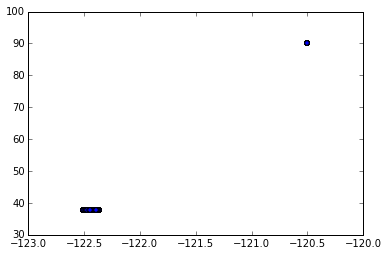

In [143]:
plt.scatter(data_xy[:,0], data_xy[:,1])

In [139]:
mini_testX, mini_test_labels = crimeX[800000:], crime_labels[800000:]
mini_devX, mini_dev_labels = crimeX[700000:800000], crime_labels[700000:800000]
mini_trainX, mini_train_labels = crimeX[:200000], crime_labels[:200000]
bnbb = BernoulliNB()
bnbb.fit(mini_trainX, mini_train_labels)
bnbb_probs = bnbb.predict_proba(mini_testX)
bnbb_accuracy = bnbb.score(mini_devX, mini_dev_labels)
# bnbb_log_loss = log_loss(mini_test_labels, bnbb_probs)
f1_score = metrics.f1_score(bnbb.predict(mini_testX), mini_test_labels)


print "BernoulliNB Results"
print "--------------------"
print "Accuracy: ", bnbb_accuracy
print "F1 Score: ", f1_score
#print "Log Loss: ", bnbb_log_loss


BernoulliNB Results
--------------------
Accuracy:  0.08441
F1 Score:  0.0797534912703


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [145]:
lr = LogisticRegression(C=0.01)
lr.fit(mini_trainX, mini_train_labels)
lr_probs = lr.predict_proba(mini_testX)
lr_accuracy = lr.score(mini_devX, mini_dev_labels)
#lr_log_loss = log_loss(mini_test_labels, lr.predict_proba(mini_testX))
f1_score = metrics.f1_score(lr.predict(mini_testX), mini_test_labels)

print "Logistic Regression Results"
print "--------------------"
print "Accuracy: ", lr_accuracy
#print "Log Loss: ", lr_log_loss
print "F1 Score: ", f1_score

Logistic Regression Results
--------------------
Accuracy:  0.18925
F1 Score:  0.270710483693


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [147]:
rfclf = RandomForestClassifier(n_estimators=50)
rfclf.fit(mini_trainX, mini_train_labels)
rfclf_probs = rfclf.predict_proba(mini_testX)
rfclf_accuracy = rfclf.score(mini_devX, mini_dev_labels)
#lr_log_loss = log_loss(mini_test_labels, lr.predict_proba(mini_testX))
f1_score = metrics.f1_score(rfclf.predict(mini_testX), mini_test_labels)

print "Random Forest Regression Results"
print "--------------------"
print "Accuracy: ", rfclf_accuracy
#print "Log Loss: ", lr_log_loss
print "F1 Score: ", f1_score

Logistic Regression Results
--------------------
Accuracy:  0.19248
F1 Score:  0.262162080132


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
